* Python code replication of:
" https://www.kaggle.com/janniskueck/pm3-notebook-newdata "
* Created by: Alexander Quispe and Anzony Quispe 



This notebook contains an example for teaching.


# A Simple Case Study using Wage Data from 2015

We illustrate how to predict an outcome variable Y in a high-dimensional setting, where the number of covariates $p$ is large in relation to the sample size $n$. So far we have used linear prediction rules, e.g. Lasso regression, for estimation.
Now, we also consider nonlinear prediction rules including tree-based methods.

## Data

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [74]:
import pandas as pd
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import random



In [75]:
rdata_read = pyreadr.read_r("../../../data/wage2015_subsample_inference.Rdata")

# Extracting the data frame from rdata_read
data = rdata_read[ 'data' ]

data.shape

(5150, 20)

In [76]:
data

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
rownames,,,,,,,,,,,,,,,,,,,,
10,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
12,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9
15,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4
18,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12
19,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32620,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9
32624,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20
32626,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6


In [77]:
data = data.reset_index().drop( 'rownames', axis = 1)

In [101]:
data

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
0,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
1,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9
2,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4
3,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12
4,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9
5146,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20
5147,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6
5148,32.967033,3.495508,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,1.00,1.000,1.0000,2920,9,6570,11


The outcomes $Y_i$'s are hourly (log) wages of never-married workers living in the U.S. The raw regressors $Z_i$'s consist of a variety of characteristics, including experience, education and industry and occupation indicators.

In [79]:
Z = data.loc[:, 'sex':'ind2']
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

The following figure shows the weekly wage distribution from the US survey data.

(0.0, 3000.0)

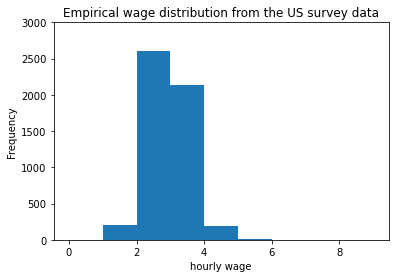

In [96]:
plt.hist(data.lwage , bins = np.arange(0, 10, 1) )
plt.xlabel('hourly wage')
plt.ylabel('Frequency')
plt.title( 'Empirical wage distribution from the US survey data' )
plt.ylim((0, 3000))

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by
the logarithm.

## Analysis

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$log(wage) = g(Z) + \epsilon.$$

We will estimate the two sets of prediction rules: Linear and Nonlinear Models.
In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$
Again, we generate $X$ in two ways:
 
1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., ${exp}^2$ and ${exp}^3$) and additional two-way interactions.


To evaluate the out-of-sample performance, we split the data first.

In [98]:
nrow = data.shape[0]
length = int(nrow*(3/4))

In [103]:
from numpy.random import default_rng


random.seed(30)
rng = default_rng()

training = rng.choice(nrow, size = length, replace=False)
training_bool = data.index.isin( training )

training_bool

array([ True,  True,  True, ...,  True,  True,  True])

In [105]:
from numpy.random import default_rng


random.seed(30)
rng = default_rng()

training = rng.choice(nrow, size = length, replace=False)

training_bool = data.index.isin( training )

data_train = data.iloc[training,:]

data_train = data[training_bool]
data_test = data[~training_bool]

In [106]:
data_train

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
0,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18
1,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9
2,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4
3,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12
4,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5143,24.038462,3.179655,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,17.0,2.89,4.913,8.3521,2550,8,9480,22
5146,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20
5147,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6
5148,32.967033,3.495508,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,1.00,1.000,1.0000,2920,9,6570,11


In [107]:
data_train.shape

(3862, 20)

In [108]:
data_test.shape

(1288, 20)

We construct the two different model matrices $X_{basic}$ and $X_{flex}$ for both the training and the test sample:

In [109]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [110]:
formula_basic =  "lwage ~ sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
formula_flex = "lwage ~ sex + exp1 + exp2 + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"

y_basic_train, model_X_basic_train = patsy.dmatrices(formula_basic, data_train, return_type='dataframe')

In [111]:
model_X_basic_train

,Intercept,occ2[T.10],occ2[T.11],occ2[T.12],occ2[T.13],occ2[T.14],occ2[T.15],occ2[T.16],occ2[T.17],occ2[T.18],...,sex,exp1,exp2,shs,hsg,scl,clg,mw,so,we
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,7.0,0.49,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.0,9.61,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.0,3.24,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,25.0,6.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,22.0,4.84,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,17.0,2.89,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5146,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,12.0,1.44,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5147,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,11.0,1.21,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,1.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [117]:
formula_basic =  "lwage ~ sex + exp1 + exp2+ shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
formula_flex = "lwage ~ sex + exp1 + exp2 + shs+hsg+scl+clg+occ2+ind2+mw+so+we + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)"

y_basic_train, model_X_basic_train = patsy.dmatrices(formula_basic, data_train, return_type='dataframe')
y_basic_test, model_X_basic_test = patsy.dmatrices(formula_basic, data_test, return_type='dataframe')
p_basic = model_X_basic_train.shape[ 1 ]

y_flex_train, model_X_flex_train = patsy.dmatrices(formula_flex, data_train, return_type='dataframe')
y_flex_test, model_X_flex_test = patsy.dmatrices(formula_flex, data_test, return_type='dataframe')
p_flex = model_X_flex_train.shape[ 1 ]

In [113]:
print(p_basic)
print(p_flex)

52
246


In [118]:
Y_train = data_train['lwage']
Y_test = data_test['lwage']

As known from our first lab, the basic model consists of $52$ regressors and the flexible model of $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression. 

### OLS

We fit the basic model to our training data by running an ols regression and compute the mean squared error on the test sample.

In [120]:
# ols (basic model)
lm_basic = sm.OLS( Y_train, model_X_basic_train )
fit_lm_basic = lm_basic.fit()

# Compute the Out-Of-Sample Performance
yhat_lm_basic = fit_lm_basic.predict( model_X_basic_test )

print( f"The mean squared error (MSE) using the basic model is equal to , {np.mean((Y_test-yhat_lm_basic)**2)} ") # MSE OLS (basic model)    

The mean squared error (MSE) using the basic model is equal to , 0.22512211116867956 


To determine the out-of-sample $MSE$ and the standard error in one step, we can use the function *lm*:

In [121]:
resid_basic = (Y_test-yhat_lm_basic)**2

MSE_lm_basic = sm.OLS( resid_basic , np.ones( resid_basic.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_basic

Coef.       0.225122
Std.Err.    0.011568
Name: const, dtype: float64

We also compute the out-of-sample $R^2$:

In [124]:
R2_lm_basic = 1 - ( MSE_lm_basic[0]/Y_test.var() )
print( f"The R^2 using the basic model is equal to, {R2_lm_basic}" ) # MSE OLS (basic model) 

The R^2 using the basic model is equal to, 0.33780239661628175


We repeat the same procedure for the flexible model.

In [125]:
# ols (flex model)
lm_flex = sm.OLS( Y_train, model_X_flex_train )
fit_lm_flex = lm_flex.fit()

yhat_lm_flex = fit_lm_flex.predict( model_X_flex_test )

resid_flex = (Y_test-yhat_lm_flex)**2

MSE_lm_flex = sm.OLS( resid_flex , np.ones( resid_flex.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_flex

R2_lm_flex = 1 - ( MSE_lm_flex[0]/Y_test.var() )

print( f"The mean squared error (MSE) using theflexible model is equal to , {np.mean((Y_test-yhat_lm_flex)**2)} ") 
print( f"The R^2 using the flex model is equal to, {R2_lm_flex}" ) # MSE OLS (flex model) 

The mean squared error (MSE) using theflexible model is equal to , 0.23373291933186335 
The R^2 using the flex model is equal to, 0.31247366946790955


We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We are proceeding by running lasso regressions and its versions.

### Lasso, Ridge and Elastic Net


Considering the basic model, we run a lasso/post-lasso regression first and then we compute the measures for the out-of-sample performance. Note that applying the package *hdm* and the function *rlasso* we rely on a theoretical based choice of the penalty level $\lambda$ in the lasso regression.

In [129]:
import hdmpy

In [135]:
fit_rlasso = hdmpy.rlasso( model_X_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post = hdmpy.rlasso( model_X_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\l

#### Estimating the predictions from rlasso models
We have to know that the residuals output come from this formula:

- x1 = x - np.ones( (x.shape[1] , 1) ) @ x.mean( axis = 0 )
- beta = model.est['beta'].loc[ fit_rlasso.est['index'].iloc[:, 0].to_list(), ].to_numpy()
- y1 = y - y.mean()
- yhat = x1 @ beta + y.mean()

So we have to apply those transfomations to original test data


In [138]:
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

In [145]:
np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T

array([[1.        , 0.05046584, 0.02096273, ..., 0.24689441, 0.30512422,
        0.20574534],
       [1.        , 0.05046584, 0.02096273, ..., 0.24689441, 0.30512422,
        0.20574534],
       [1.        , 0.05046584, 0.02096273, ..., 0.24689441, 0.30512422,
        0.20574534],
       ...,
       [1.        , 0.05046584, 0.02096273, ..., 0.24689441, 0.30512422,
        0.20574534],
       [1.        , 0.05046584, 0.02096273, ..., 0.24689441, 0.30512422,
        0.20574534],
       [1.        , 0.05046584, 0.02096273, ..., 0.24689441, 0.30512422,
        0.20574534]])

In [153]:
fit_rlasso.est['index'].iloc[:, 0].to_list()

[False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True]

In [155]:
fit_rlasso.est['beta'].loc[ fit_rlasso.est['index'].iloc[:, 0].to_list(), ]

,0
V2,0.012116
V3,-0.272249
V5,-0.223134
V6,-0.272104
V7,-0.289580
V8,-0.001120
V9,-0.224046
V12,0.032854
V14,-0.053768
V15,-0.157235


In [157]:
# Getting mean of each variable
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_basic_test.to_numpy() - \
                    (np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)


# Getting the significant variables
x1_est_rlasso = new_x1[ :, fit_rlasso.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso = fit_rlasso.est['beta'].loc[ fit_rlasso.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()



# yhat
yhat_rlasso = (x1_est_rlasso @ beta_rlasso) + np.mean( Y_test.to_numpy() )
residuals_rlasso = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso

In [158]:
# Post Lasso

# Getting mean of each variable
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_basic_test.to_numpy() - \
                    (np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post = new_x1[ :, fit_rlasso_post.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post = fit_rlasso_post.est['beta'].loc[ fit_rlasso_post.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post = (x1_est_rlasso_post @ beta_rlasso_post) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post

In [159]:
MSE_lasso = sm.OLS( ( residuals_rlasso )**2 , np.ones( yhat_rlasso.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post = sm.OLS( ( residuals_rlasso_post )**2  , np.ones( yhat_rlasso_post.size )  ).fit().summary2().tables[1].round(3)

R2_lasso = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post = 1 - MSE_lasso_post.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso},for lasso and {R2_lasso_post} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.28171533559738904,for lasso and 0.3023218628548411 for post-lasso


Now, we repeat the same procedure for the flexible model.

In [160]:
fit_rlasso_flex = hdmpy.rlasso( model_X_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post_flex = hdmpy.rlasso( model_X_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\l

In [161]:
# Getting mean of each variable
meanx = model_X_flex_test.mean( axis = 0 ).values.\
                        reshape( model_X_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_flex_test.to_numpy() - \
                    (np.ones( ( model_X_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_flex = new_x1[ :, fit_rlasso_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_flex = fit_rlasso_flex.est['beta'].loc[ fit_rlasso_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_flex = (x1_est_rlasso_flex @ beta_rlasso_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_flex

In [162]:
# Getting mean of each variable
meanx = model_X_flex_test.mean( axis = 0 ).values.\
                        reshape( model_X_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_flex_test.to_numpy() - \
                    (np.ones( ( model_X_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post_flex = new_x1[ :, fit_rlasso_post_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post_flex = fit_rlasso_post_flex.est['beta'].loc[ fit_rlasso_post_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post_flex = (x1_est_rlasso_post_flex @ beta_rlasso_post_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post_flex

In [163]:
MSE_lasso_flex = sm.OLS( ( residuals_rlasso_flex )**2 , np.ones( yhat_rlasso_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post_flex = sm.OLS( ( residuals_rlasso_post_flex )**2  , np.ones( yhat_rlasso_post_flex.size )  ).fit().summary2().tables[1].round(3)

R2_lasso_flex = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post_flex = 1 - MSE_lasso_post_flex.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso_flex} for lasso and {R2_lasso_post_flex} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.28171533559738904 for lasso and 0.28171533559738904 for post-lasso


It is worth to notice that lasso regression works better for the more complex model.

In contrast to a theoretical based choice of the tuning parameter $\lambda$ in the lasso regression, we can also use cross-validation to determine the penalty level by applying the package *glmnet* and the function cv.glmnet. In this context, we also run a ridge and a elastic net regression by adjusting the parameter *alpha*.

In [165]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV
import statsmodels.api as sm

In [170]:
Y_vec = Y_train.to_numpy().reshape( Y_train.to_numpy().size, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )

std_Y = scaler.transform( Y_vec )

std_Y 

array([[-1.25006172],
       [ 1.59298276],
       [-1.00317464],
       ...,
       [ 1.1988035 ],
       [ 0.92649897],
       [-0.21174665]])

In [171]:
# Reshaping Y variable
Y_vec = Y_train.to_numpy().reshape(-1, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )  # mean and standar deviation
std_Y = scaler.transform( Y_vec )  # scale 

# Regressions
fit_lasso_cv_basic = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( model_X_basic_train, std_Y )

fit_ridge_basic = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( model_X_basic_train , std_Y )
fit_elnet_basic = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( model_X_basic_train , std_Y )



# Predictions

yhat_lasso_cv_basic = scaler.inverse_transform( fit_lasso_cv_basic.predict( model_X_basic_test ).reshape(-1, 1) )
yhat_ridge_basic = scaler.inverse_transform( fit_ridge_basic.predict( model_X_basic_test ).reshape(-1, 1) )
yhat_elnet_basic = scaler.inverse_transform( fit_elnet_basic.predict( model_X_basic_test ).reshape(-1, 1) )

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\User

In [172]:
MSE_lasso_cv_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_lasso_cv_basic)**2 ) , np.ones( yhat_lasso_cv_basic.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_ridge_basic)**2 ) , np.ones( yhat_ridge_basic.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_elnet_basic)**2 ) , np.ones( yhat_elnet_basic.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [173]:
R2_lasso_cv_basic = 1- MSE_ridge_basic.iloc[0,0] / np.var( Y_test )
R2_ridge_basic = 1- MSE_lasso_cv_basic.iloc[0,0] / np.var( Y_test )
R2_elnet_basic = 1- MSE_elnet_basic.iloc[0,0] / np.var( Y_test )

In [174]:
print( f"R^2 using cross-validation for lasso, ridge and elastic net in the basic model: {R2_lasso_cv_basic},{R2_ridge_basic},{R2_elnet_basic}")

R^2 using cross-validation for lasso, ridge and elastic net in the basic model: 0.00499911242589135,0.33764733815333003,0.33470354854512263


In [175]:
# Reshaping Y variable
Y_vec = Y_train.to_numpy().reshape( -1, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )
std_Y = scaler.transform( Y_vec )

# Regressions
fit_lasso_cv_flex = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( model_X_flex_train, std_Y )
fit_ridge_flex = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( model_X_flex_train , std_Y )
fit_elnet_flex = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( model_X_flex_train , std_Y )

# Predictions
yhat_lasso_cv_flex = scaler.inverse_transform( fit_lasso_cv_flex.predict( model_X_flex_test ).reshape(-1,1) )
yhat_ridge_flex = scaler.inverse_transform( fit_ridge_flex.predict( model_X_flex_test ).reshape(-1,1) )
yhat_elnet_flex = scaler.inverse_transform( fit_elnet_flex.predict( model_X_flex_test ).reshape(-1,1) )

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6422395786266861, tolerance: 0.3517454285165372
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8642717990524034, tolerance: 0.3517454285165372
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: Convergenc

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1306750050366645, tolerance: 0.34646255829312006
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6257175114324127, tolerance: 0.34646255829312006
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8495809347214163, tolerance: 0.34646255829312006
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9551522175288483, tolerance: 0.3496013103102586
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0811896828545287, tolerance: 0.3496013103102586
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9882073821036101, tolerance: 0.3496013103102586
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.68641775553715, tolerance: 0.3398317174716308
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.728888513090169, tolerance: 0.3398317174716308
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.515845407874167, tolerance: 0.3398317174716308
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.383911657936551, tolerance: 0.34332305087359727
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.457426640658923, tolerance: 0.34332305087359727
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6661269118649216, tolerance: 0.34332305087359727
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0845889312636245, tolerance: 0.3422305952643562
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2067192599542977, tolerance: 0.3422305952643562
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8161039265860381, tolerance: 0.3422305952643562
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

In [176]:
MSE_lasso_cv_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_lasso_cv_flex)**2 ) , np.ones( yhat_lasso_cv_flex.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_ridge_flex)**2 ) , np.ones( yhat_ridge_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_elnet_flex)**2 ) , np.ones( yhat_elnet_flex.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [177]:
R2_lasso_cv_flex = 1- MSE_ridge_flex.iloc[0,0] / np.var( Y_test )
R2_ridge_flex = 1- MSE_lasso_cv_flex.iloc[0,0] / np.var( Y_test )
R2_elnet_flex = 1- MSE_elnet_flex.iloc[0,0] / np.var( Y_test )

In [178]:
print( f"R^2 using cross-validation for lasso, ridge and elastic net in the basic model: {R2_lasso_cv_flex},{R2_ridge_flex},{R2_elnet_flex}")

R^2 using cross-validation for lasso, ridge and elastic net in the basic model: 0.010886691642306157,0.33764733815333003,0.22578333304144804


The performance of the lasso regression with cross-validated penalty is quite similar to the performance of lasso using a theoretical based choice of the tuning parameter.

## Non-linear models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are applying regression trees, random forests, boosted trees and neural nets to estimate the regression function $g(X)$. First, we load the relevant libraries

and we illustrate the application of regression trees.

### Regression Trees

We fit a regression tree to the training data using the basic model. The variable *cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

In [180]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from scipy.sparse import diags
from IPython.display import Image, display
from sklearn.model_selection import cross_val_score

**cp** = It is the amout by which splitting that node would decarease the relative error.\
It has the same meaning as min_impurity_decrease 
Apparently, Sklearn does not have tree prune function as stated in theis user guide. I take the info from [this link](https://stats.stackexchange.com/questions/152553/what-is-the-equivalent-of-the-complexity-parameter-rpart-in-r-in-python-for)

we can Preprune and postprune decission trees.

Preprunning is stopping the growth of decision tree on an early stage. we can limit paramters like max_depth, min_samples. We can grid search those parameters and choose the optimum values that gives better performance on test data. 

Cost complexity pruning\
It is all about finding the right parameter for alpha. We will get the alpha values for this tree

we are going to cut some threes in order to not overfitting data. We will calculate the total sum of squared residuals from each leaf of each type of three and store that results.

how to compare these threes?

Tree Scores = SSR + alpha(Number of leafs) We will penalize for each additional three.
We will get the alpha value from cross validation. We can check the code [here](https://www.kaggle.com/arunmohan003/pruning-decision-trees).

cp = It is the minimum value that the R-squared should decrease in order to make the next splitting \
Xerror = Cross-Validated Error Rate 

### scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [48]:
trees = DecisionTreeRegressor( random_state = 0, min_impurity_decrease = 0 )

# min_impurity_decrease 0 : depeer tree , min_impurity_decrease = 1 : little tree

In [49]:
trees_fit =  trees.fit( model_X_basic_train, y_basic_train )

In [51]:
trees_fit.get_depth()  

43

In [52]:
trees_fit.get_n_leaves() # number os leaves tree

3509

In [53]:
dir(trees_fit)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_prune_tree',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_X_predict',
 '_validate_data',
 'apply',
 'ccp_alpha',
 'class_weight',
 'cost_complexity_pruning_path',
 'criterion',
 'decision_path',
 'feature_importances_',
 'feature_names_in_',
 'fit',
 'get_depth',
 'get_n_leaves',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_

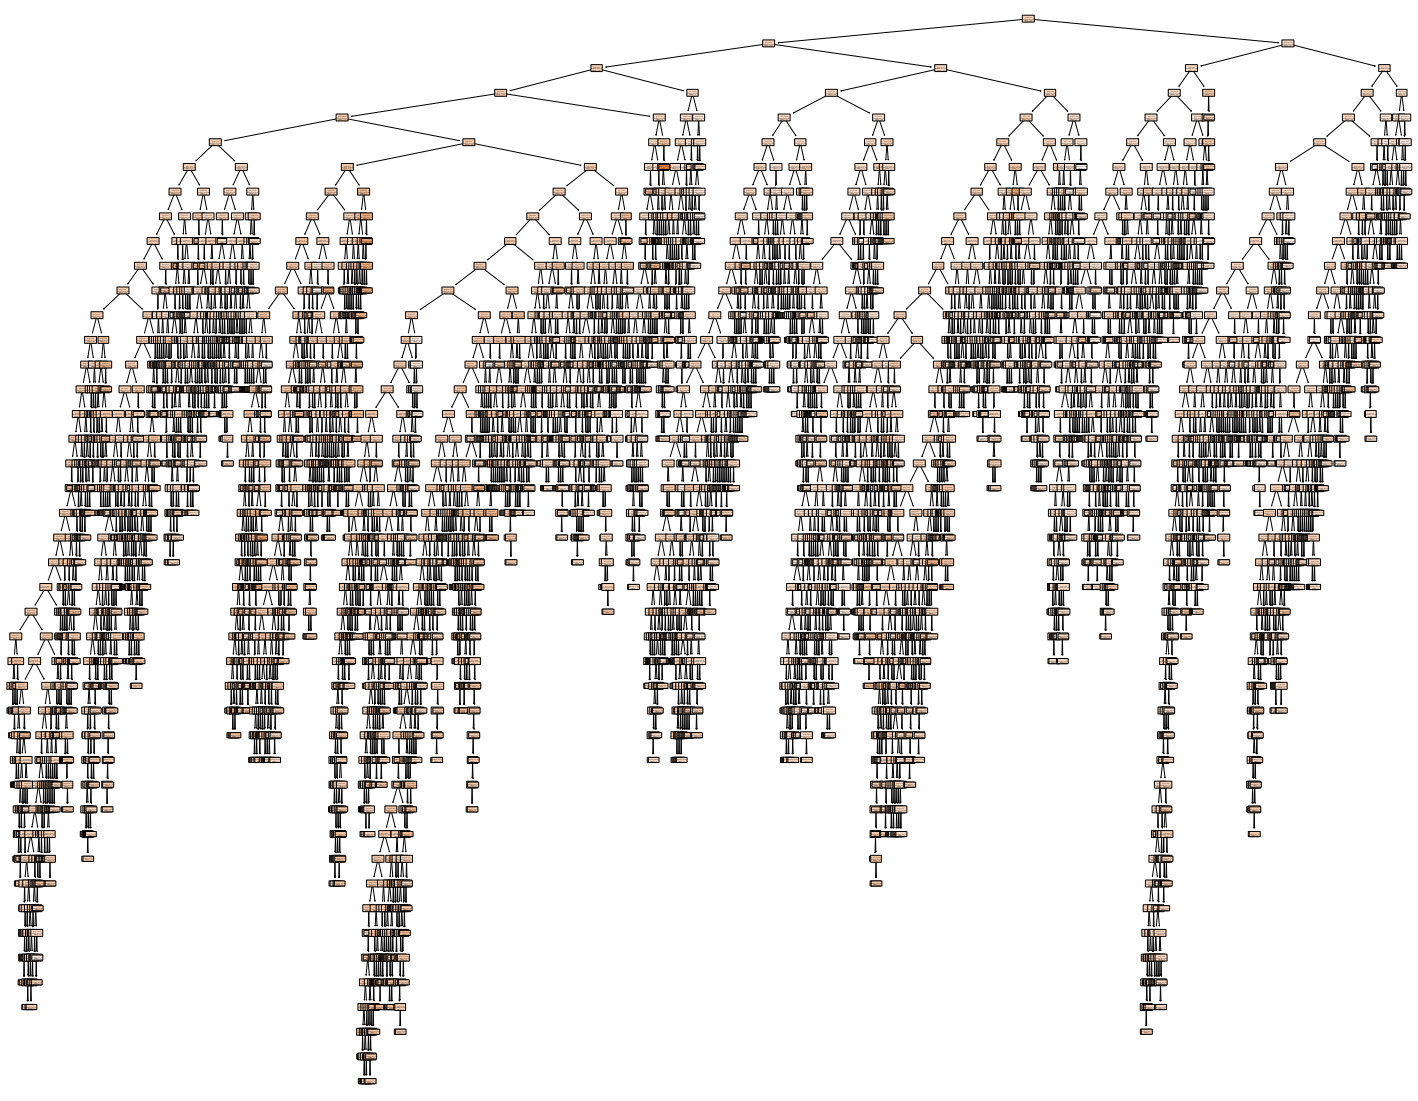

In [54]:
# tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree( trees_fit , filled = True , rounded = True  )

An important method to improve predictive performance is called "Pruning the Tree". This
means the process of cutting down the branches of a tree. We apply pruning to the complex tree above to reduce the depth. Initially, we determine the optimal complexity of the regression tree.

Now, we can prune the tree and visualize the prediction rule.

## cost_complexity_pruning_path:

DecisionTree in sklearn has a function called cost_complexity_pruning_path, which gives the effective alphas of subtrees during pruning and also the corresponding impurities. In other words, we can use these values of alpha to prune our decision tree-

In [55]:
trees = DecisionTreeRegressor( random_state = 0, min_impurity_decrease = 0.001 )

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

In [56]:
path = trees.cost_complexity_pruning_path( model_X_basic_train, y_basic_train )

alphas, impurities = path.ccp_alphas, path.impurities

In [57]:
alphas

array([0.        , 0.00113862, 0.00120799, 0.00122381, 0.00143101,
       0.00145086, 0.00156149, 0.00161479, 0.00194509, 0.00197071,
       0.00264502, 0.00357992, 0.00384913, 0.00551844, 0.01805004,
       0.01920265])

In [181]:
mean1, std1 = [], []

for i in alphas:
     tree_initial = DecisionTreeRegressor(ccp_alpha=i, random_state=0)
# 10 fold cross validation for each alpha value
     scores = cross_val_score(tree_initial, model_X_basic_train, y_basic_train, scoring='neg_mean_squared_error', cv=10)
     mean1.append(scores.mean()), std1.append(scores.std())
            
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies

table = pd.DataFrame({"alpha": alphas, "mean": mean1, "std": std1})
table["mean"] = (-1)*table["mean"]
table = table.sort_values(["mean"], ascending = True)
table.head(10)


,alpha,mean,std
1,0.001139,0.263486,0.026331
2,0.001208,0.265531,0.025885
3,0.001224,0.265899,0.025577
4,0.001431,0.268022,0.025722
5,0.001451,0.268382,0.025728
6,0.001561,0.268853,0.024991
8,0.001945,0.269636,0.026476
9,0.001971,0.269636,0.026476
7,0.001615,0.269782,0.024663
10,0.002645,0.276192,0.026857


In [59]:
prune_tree =  DecisionTreeRegressor(ccp_alpha=table.iloc[1,0], random_state=0)

prune_tree_fit = prune_tree.fit(model_X_basic_train, y_basic_train)

In [60]:
prune_tree_fit.get_depth()  # depth's tree

8

In [61]:
prune_tree_fit.get_n_leaves() # number leaves tree

21

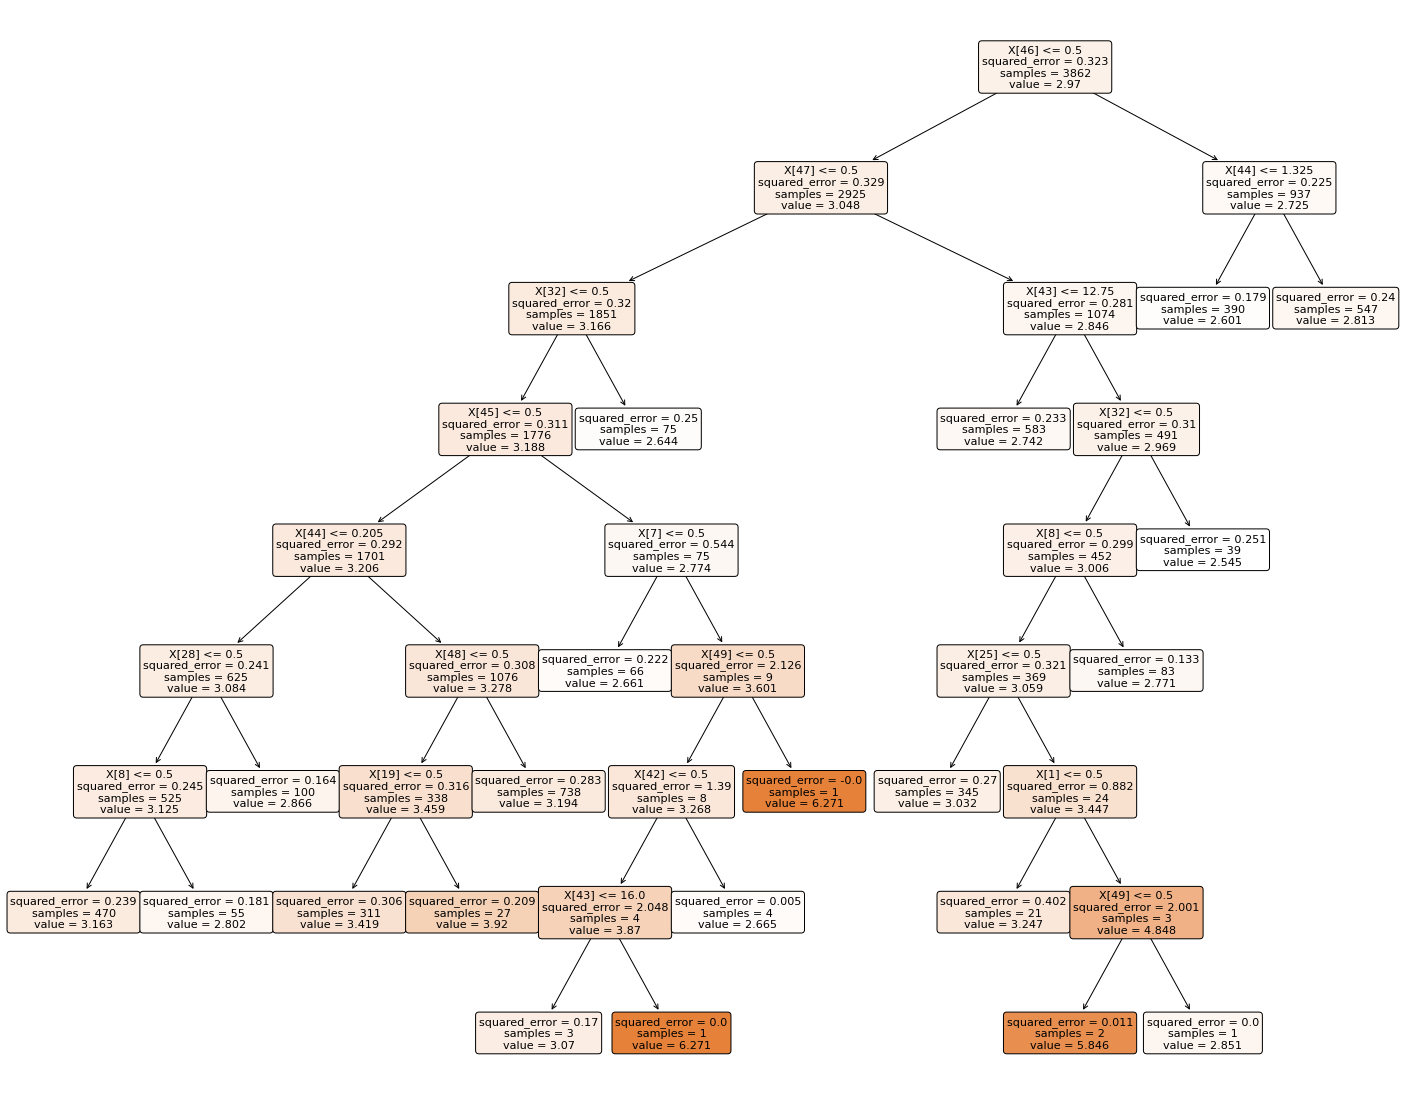

In [62]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree( prune_tree_fit , filled = True , rounded = True  )

In [64]:
list(model_X_basic_train.columns)[46]

'hsg'

In [65]:
list(model_X_basic_train.columns)[47]

'scl'

In [66]:
#Using  GridSearchCV

from sklearn.model_selection import GridSearchCV

In [67]:
param_grid = {
 "max_depth":list(range(5,15,2)),
 "min_samples_split":list(range(2, 300,10)),
 "ccp_alpha": [x/10000 for x in range(10, 50,2)]
}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, cv=10, n_jobs=-1)
gridSearch.fit(model_X_basic_train, y_basic_train)
print("score: ", gridSearch.best_score_)
print("parameters: ", gridSearch.best_params_)

score:  0.1908114267806939
parameters:  {'ccp_alpha': 0.001, 'max_depth': 11, 'min_samples_split': 182}


In [68]:
prunedtree2 = DecisionTreeRegressor(random_state = 0, max_depth=13, ccp_alpha=0.001, min_samples_split=102)
prune_tree_fit2 = prunedtree2.fit(model_X_basic_train, y_basic_train)

In [69]:
prune_tree_fit2.get_depth()

10

In [70]:
prune_tree_fit2.get_n_leaves()

20

In [71]:
model_X_basic_train.columns

Index(['Intercept', 'occ2[T.10]', 'occ2[T.11]', 'occ2[T.12]', 'occ2[T.13]',
       'occ2[T.14]', 'occ2[T.15]', 'occ2[T.16]', 'occ2[T.17]', 'occ2[T.18]',
       'occ2[T.19]', 'occ2[T.2]', 'occ2[T.20]', 'occ2[T.21]', 'occ2[T.22]',
       'occ2[T.3]', 'occ2[T.4]', 'occ2[T.5]', 'occ2[T.6]', 'occ2[T.7]',
       'occ2[T.8]', 'occ2[T.9]', 'ind2[T.11]', 'ind2[T.12]', 'ind2[T.13]',
       'ind2[T.14]', 'ind2[T.15]', 'ind2[T.16]', 'ind2[T.17]', 'ind2[T.18]',
       'ind2[T.19]', 'ind2[T.2]', 'ind2[T.20]', 'ind2[T.21]', 'ind2[T.22]',
       'ind2[T.3]', 'ind2[T.4]', 'ind2[T.5]', 'ind2[T.6]', 'ind2[T.7]',
       'ind2[T.8]', 'ind2[T.9]', 'sex', 'exp1', 'exp2', 'shs', 'hsg', 'scl',
       'clg', 'mw', 'so', 'we'],
      dtype='object')

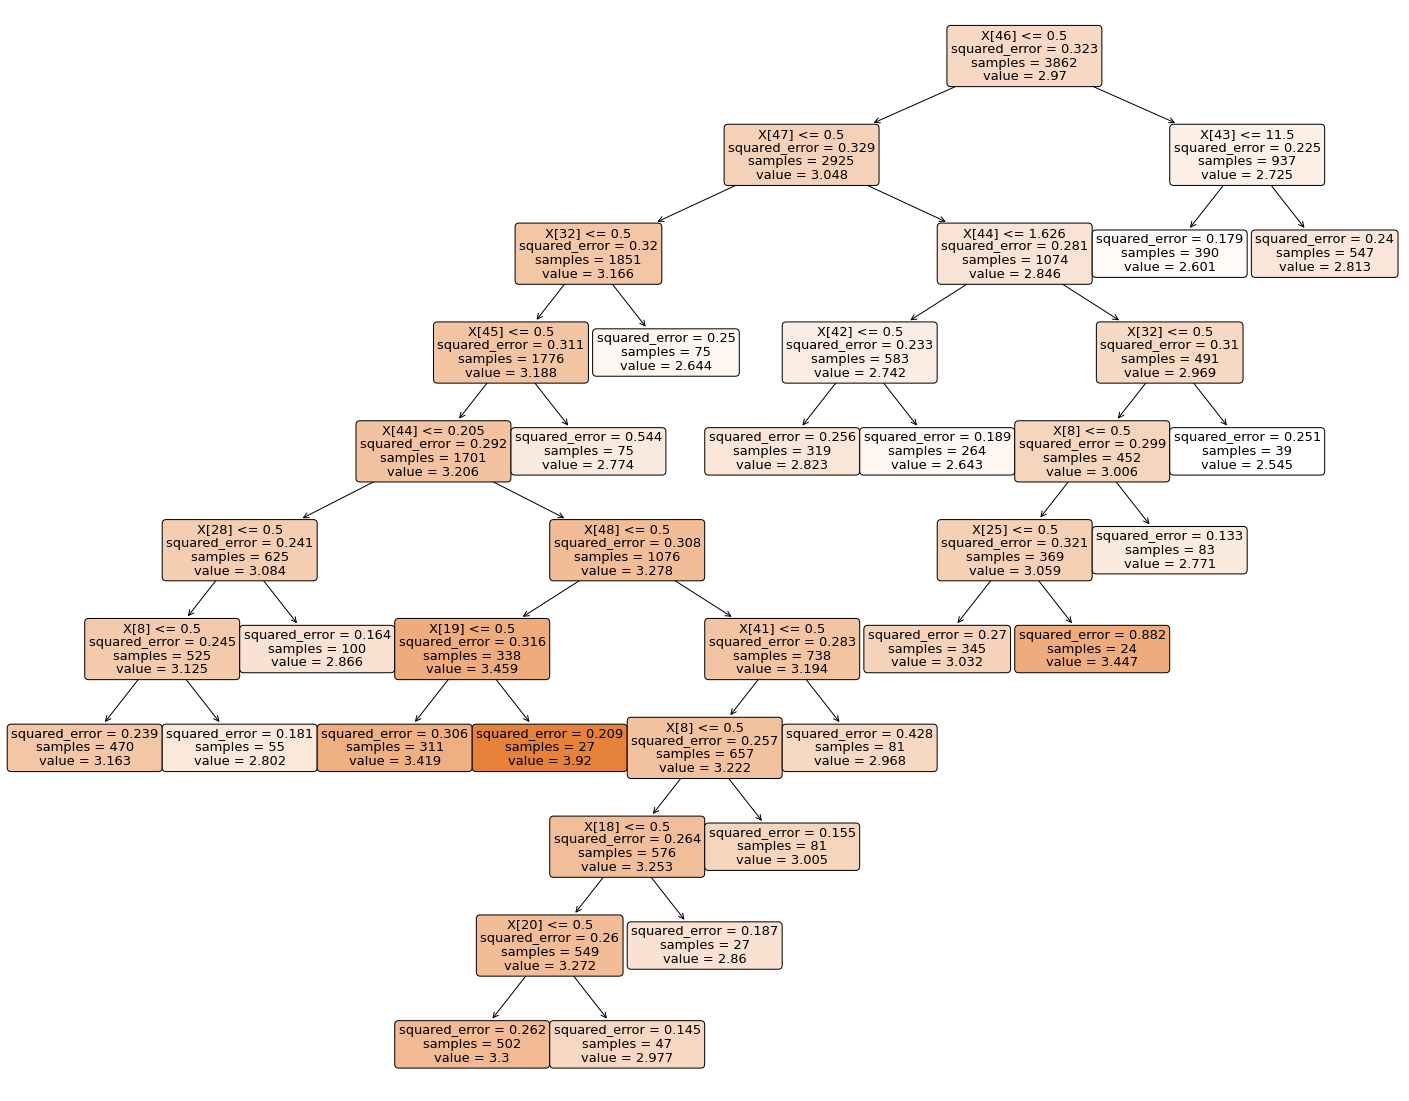

In [72]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree( prune_tree_fit2 , filled = True , rounded = True )

In [73]:
y_hat_pt = prune_tree_fit.predict(model_X_basic_test)

MSE_pt= sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - y_hat_pt.reshape(-1,1))**2 ) , np.ones( y_hat_pt.shape )  ).fit().summary2().tables[1].round(3)
R2_pt = 1- MSE_pt.iloc[0,0] / np.var( Y_test )

print( f"R^2 using prune tree: {R2_pt}")

R^2 using prune tree: 0.1963567239574815


E.g., in the pruned tree the predicted hourly log wage for high-school graduates with more than $9.5$ years of experience is $2.8$, and otherwise is $2.6$.

Finally, we calculate the mean-squared error and the $R^2$ on the test sample to evaluate the out-of-sample performance of the pruned tree.

### Random Forest and Boosted Trees

In the next step, we apply the more advanced tree-based methods random forest and boosted trees.

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [70]:
fit_rf = RandomForestRegressor( random_state = 0 , n_estimators = 500 , max_features = p_basic , n_jobs = 4 , min_samples_leaf = 5 ).fit( model_X_basic_train, y_basic_train )
fit_boost = GradientBoostingRegressor( random_state = 0 , n_estimators = 500 , max_features = p_basic , min_samples_leaf = 5 ).fit( model_X_basic_train, y_basic_train )

C:\Users\Roberto\AppData\Local\Temp\ipykernel_18804\3760450971.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit_rf = RandomForestRegressor( random_state = 0 , n_estimators = 500 , max_features = p_basic , n_jobs = 4 , min_samples_leaf = 5 ).fit( model_X_basic_train, y_basic_train )
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [71]:
y_hat_rf = fit_rf.predict(model_X_basic_test)
y_hat_boost = fit_boost.predict(model_X_basic_test)

MSE_rf= sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - y_hat_rf.reshape(-1,1))**2 ) , np.ones( y_hat_rf.shape )  ).fit().summary2().tables[1].round(3)
R2_rf = 1- MSE_rf.iloc[0,0] / np.var( Y_test )

MSE_boost= sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - y_hat_boost.reshape(-1,1))**2 ) , np.ones( y_hat_boost.shape )  ).fit().summary2().tables[1].round(3)
R2_boost = 1- MSE_boost.iloc[0,0] / np.var( Y_test )

To conclude, let us have a look at our results.

## Results

In [72]:
table= np.zeros( (15, 3) )
table[0,0:2]   = MSE_lm_basic
table[1,0:2]   = MSE_lm_flex
table[2,0:2]   = MSE_lasso.iloc[0, [0, 1]]
table[3,0:2]   = MSE_lasso_post.iloc[0, [0, 1]]
table[4,0:2]   = MSE_lasso_flex.iloc[0, [0, 1]]
table[5,0:2]   = MSE_lasso_post_flex.iloc[0, [0, 1]]
table[6,0:2]   = MSE_lasso_cv_basic.iloc[0, [0, 1]]
table[7,0:2]   = MSE_ridge_basic.iloc[0, [0, 1]]
table[8,0:2]   = MSE_elnet_basic.iloc[0, [0, 1]]
table[9,0:2]   = MSE_lasso_cv_flex.iloc[0, [0, 1]]
table[10,0:2]  = MSE_ridge_flex.iloc[0, [0, 1]]
table[11,0:2]  = MSE_elnet_flex.iloc[0, [0, 1]]
table[12,0:2]  = MSE_rf.iloc[0, [0, 1]]
table[13,0:2]  = MSE_boost.iloc[0, [0, 1]]
table[14,0:2]  = MSE_pt.iloc[0, [0, 1]]



table[0,2]   = R2_lm_basic
table[1,2]   = R2_lm_flex
table[2,2]   = R2_lasso
table[3,2]   = R2_lasso_post
table[4,2]   = R2_lasso_flex
table[5,2]   = R2_lasso_post_flex
table[6,2]   = R2_lasso_cv_basic
table[7,2]   = R2_ridge_basic
table[8,2]   = R2_elnet_basic
table[9,2]   = R2_lasso_cv_flex
table[10,2]  = R2_ridge_flex
table[11,2]  = R2_elnet_flex
table[12,2]  = R2_rf
table[13,2]  = R2_boost
table[14,2]  = R2_pt




colnames_table= ["MSE", "S_E_ for MSE", "R-squared"]
rownames_table= ["Least Squares (basic)","Least Squares (flexible)", "Lasso", "Post-Lasso","Lasso (flexible)","Post-Lasso (flexible)", \
                    "Cross-Validated lasso", "Cross-Validated ridge","Cross-Validated elnet","Cross-Validated lasso (flexible)","Cross-Validated ridge (flexible)","Cross-Validated elnet (flexible)",  \
                    "Random Forest","Boosted Trees", "Pruned Tree"]
table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round(3)
table_html = table_pandas.to_latex()
table_pandas

C:\Users\Roberto\AppData\Local\Temp\ipykernel_18804\1431904078.py:47: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_html = table_pandas.to_latex()


,MSE,S_E_ for MSE,R-squared
Least Squares (basic),0.229,0.018,0.274
Least Squares (flexible),0.261,0.025,0.173
Lasso,0.233,0.017,0.261
Post-Lasso,0.232,0.018,0.264
Lasso (flexible),0.234,0.017,0.261
Post-Lasso (flexible),0.233,0.018,0.261
Cross-Validated lasso,0.229,0.018,0.004
Cross-Validated ridge,0.314,0.017,0.274
Cross-Validated elnet,0.228,0.018,0.277
Cross-Validated lasso (flexible),0.229,0.018,0.014


Above, we displayed the results for a single split of data into the training and testing part. The table shows the test MSE in column 1 as well as the standard error in column 2 and the test $R^2$
in column 3. We see that the prediction rule produced by Elastic Net using the flexible model performs the best here, giving the lowest test MSE. Cross-Validated Lasso and Ridge, perform nearly as well. For any two of these methods, their testing MSEs are within one standard error of each other. Remarkably, OLS on a simple model performs extremely well, almost as well as best tree based method Random Forest. On the other hand, OLS on a flexible model with many regressors performs very poorly giving the highest test MSE. It is worth to notice that the nonlinear models, e.g. Random Forest, are not tuned. Thus, there is a lot of potential to improve the performance of the nonlinear methods we used in the analysis.

### Ensemble learning

In the final step, we can build a prediction model by combing the strengths of the models we considered so far. This ensemble method is of the form
	$$ f(x) = \sum_{k=1}^K \alpha_k f_k(x) $$
where the $f_k$'s denote our prediction rules from the table above and the $\alpha_k$'s are the corresponding weights.

We focus on the prediction rules based on OLS, Post-Lasso, Elastic Net, Pruned Tree, Random Forest, Boosted Trees, and Neural Network and combine these methods into an ensemble method. The weights can be determined by a simple ols regression:

Alternatively, we can determine the weights via lasso regression. 

In [73]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [74]:
data_ensemble = pd.DataFrame({"Y_test":Y_test, "yhat_lm_basic":yhat_lm_basic,
                              "yhat_rlasso_post_flex":yhat_rlasso_post_flex[:,0], 
                              "yhat_elnet_flex":yhat_elnet_flex[:,0],
                              "y_hat_rf": y_hat_rf, "y_hat_boost": y_hat_boost, "y_hat_pt": y_hat_pt})

ensemble_ols = smf.ols( "Y_test ~ yhat_lm_basic + yhat_rlasso_post_flex + yhat_elnet_flex+ y_hat_rf + y_hat_boost +y_hat_pt ", data_ensemble ) 


ensemble_ols.fit().summary2().tables[1]


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,0.109380,0.146391,0.747177,0.455094,-0.177813,0.396574
yhat_lm_basic,0.315401,0.162684,1.938730,0.052754,-0.003756,0.634558
yhat_rlasso_post_flex,0.246488,0.119153,2.068671,0.038777,0.012732,0.480244
yhat_elnet_flex,-0.046404,0.158975,-0.291895,0.770414,-0.358284,0.265476
y_hat_rf,0.191154,0.107778,1.773590,0.076369,-0.020287,0.402594
y_hat_boost,0.380999,0.118072,3.226828,0.001283,0.149363,0.612636
y_hat_pt,-0.122225,0.089858,-1.360195,0.174008,-0.298511,0.054061


In [75]:
data_ensemble.iloc[:,1:7]

,yhat_lm_basic,yhat_rlasso_post_flex,yhat_elnet_flex,y_hat_rf,y_hat_boost,y_hat_pt
0,2.730100,2.794159,2.742585,3.000116,2.742597,3.014431
3,3.869286,3.559957,3.815292,3.476251,3.646645,3.417257
5,3.134586,3.287304,3.085259,3.301408,3.239761,3.329601
8,2.675587,2.707716,2.697673,2.442452,2.381198,2.790351
12,2.456044,2.468741,2.494138,2.527736,2.511794,2.768408
...,...,...,...,...,...,...
5140,3.181650,3.234154,3.132455,3.173697,3.119288,3.014431
5143,3.194325,3.184070,3.265116,3.226768,3.205398,3.417257
5144,3.349706,3.264759,3.393248,3.190225,3.220190,3.014431
5145,2.983851,3.040670,2.975022,2.773477,2.961044,3.014431


The estimated weights are shown in the following table.

In [76]:
hdmpy.rlasso(data_ensemple.iloc[:,1:7], data_ensemple.iloc[:,0])

ensemble_lasso = hdmpy.rlasso(data_ensemple.iloc[:,1:7], data_ensemple.iloc[:,0])

NameError: name 'data_ensemple' is not defined

In [ ]:
ensemble_ols.fit().summary2().tables[1]

In [ ]:
ensemble_lasso.est['coefficients']


In [ ]:
table= np.zeros( (7, 2) )
table[0:7,0]   = ensemble_ols.fit().summary2().tables[1].iloc[:,0]
table[0:7,1]   = ensemble_lasso.est['coefficients'].iloc[:,0]
table

colnames_table= ["Weight OLS", "Weight Lasso"]
rownames_table= ["Constant","Least Squares (basic)","Post-Lasso (flexible)", "Cross-Validated elnet (flexible)",
                    "Random Forest","Boosted Trees", "Prune tree"]
table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round(3)
table_html = table_pandas.to_latex()
table_pandas


Further, the $R^2$ for the test sample gets improved from $30\%$ obtained by OLS to about $31\%$ obtained by the ensemble method. We see that it is very powerful to aggregate prediction rules into an ensemble rule. Nevertheless, it is worth to notice that we should compare the ensemble method and the single rules on an additional validation set to ensure a fair comparison.

### References

https://patsy.readthedocs.io/en/latest/API-reference.html